In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import VotingClassifier

In [2]:
pd.set_option('display.max_columns', 100)

### [U.S. Opiate Prescriptions/Overdoses](https://www.kaggle.com/apryor6/us-opiate-prescriptions) on Kaggle has a subset of the data from [cms.gov](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Part-D-Prescriber.html): Medicare Provider Charge Data. 

#### The data decription as written on Kaggle is as follows:

- NPI – unique National Provider Identifier number
- Gender - (M/F)
- State - U.S. State by abbreviation
- Credentials - set of initials indicative of medical degree
- Specialty - description of type of medicinal practice
- A long list of drugs with numeric values indicating the total number of prescriptions written for the year by that individual
- Opioid.Prescriber - a boolean label indicating whether or not that individual prescribed opiate drugs more than 10 times in the year

#### The objective of this project is to:
- Find features which will be useful for classfying whether a prescriber would prescribe opioids
- Make a prediction model which will learn from prescribers who prescribed opioids, to predict the likelihood of a prescriber to prescribe opioids.

In [5]:
Prescriber = pd.read_csv('data/prescriber-info.csv')
Prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,0,0,0,21,0,...,0,0,0,0,0,0,0,0,0,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,15,0,...,0,0,0,0,0,25,0,0,0,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


### Data Exploration:

In [6]:
Prescriber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 256 entries, NPI to Opioid.Prescriber
dtypes: int64(252), object(4)
memory usage: 48.8+ MB


In [7]:
Prescriber.isnull().values.any()

True

In [8]:
Prescriber = Prescriber.dropna()

In [9]:
Prescriber.describe()

,NPI,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.423700e+04,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.00000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.00000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,...,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000
mean,1.498151e+09,3.190329,2.414655,1.068202,7.113958,0.719974,9.032471,9.415109,16.360358,2.411726,4.414655,44.677559,2.865247,6.003177,2.817098,1.002269,15.89483,39.944754,1.541115,7.651896,3.314560,3.126707,3.827165,1.639105,0.973677,2.731237,0.899534,1.294962,1.139621,2.223914,3.052110,2.900978,2.378265,1.274333,2.990923,1.48459,0.645996,16.706110,0.859636,3.462887,4.328135,1.150968,1.377109,0.911705,7.337459,12.653134,1.046458,1.723068,11.460412,5.571688,...,7.938565,1.371746,0.772497,2.962042,1.058794,8.994801,1.691546,5.530841,3.100507,1.053431,13.844824,41.595577,1.168874,6.761439,5.742212,1.207410,4.341008,0.889219,3.428807,6.559929,14.853530,3.855675,2.237076,2.506705,3.384000,0.608780,2.744935,0.720097,1.246689,16.477658,2.147502,11.912118,3.689359,5.537071,0.963568,0.828692,3.911829,0.828980,4.579486,2.244832,2.217024,2.267772,2.560672,0.819697,19.404629,3.393861,4.118208,1.138260,11.721541,0.589223
std,2.878020e+08,20.920849,11.777393,6.729293,26.079657,5.282100,36.804320,29.511625,70.143701,14.227994,14.963181,115.907289,14.343846,17.039946,10.503986,12.422828,47.36018,108.731350,13.541937,22.006734,16.490458,15.361375,18.402725,9.445709,7.132309,24.578442,7.457461,13.794411,8.346469,10

In [10]:
Prescriber['Gender'].value_counts()

M    15164
F     9073
Name: Gender, dtype: int64

### Data Cleaning:

#### Assign binary variables for 'Gender' attribute

<AxesSubplot:>

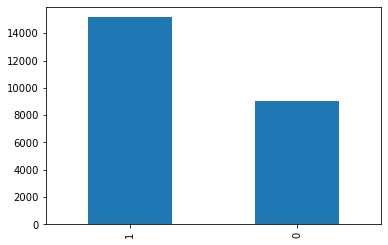

In [11]:
# creating a dict file 
gender = {'M': 1,'F': 0}
Prescriber.Gender = [gender[item] for item in Prescriber.Gender]
Prescriber['Gender'].value_counts().plot(kind='bar')

In [12]:
# Check the speciality of the prescribers
Prescriber['Specialty'].value_counts()

Internal Medicine                  3102
Family Practice                    2921
Dentist                            2677
Nurse Practitioner                 2398
Physician Assistant                1785
                                   ... 
Midwife                               1
Licensed Clinical Social Worker       1
Community Health Worker               1
Health Maintenance Organization       1
Specialist/Technologist               1
Name: Specialty, Length: 108, dtype: int64

In [13]:
# How many unique specialty? 
len(Prescriber['Specialty'].unique())

108

In [14]:
specialty = pd.DataFrame(Prescriber.groupby(['Specialty']).count()['NPI']).sort_values('NPI')

In [15]:
specialty.loc[specialty['NPI']<40].shape

(63, 1)

#### Out of the 108 unique specialities 63 have a count of less than 40. These need to be adjusted in other or associated with a generic speciality. 

In [16]:
rareSpecialty = list(specialty.loc[specialty['NPI']<40].index)

#### Some of these rare specialities will be of the category surgery and the rest will be combined into the 'Other' category.

In [17]:
Prescriber.loc[Prescriber['Specialty'].isin(rareSpecialty),'Specialty'] = Prescriber.loc[Prescriber['Specialty'].isin(rareSpecialty),'Specialty'].apply(lambda x: 'Surgery' if 'Surgery' in list(x.split( )) else 'Other')

In [18]:
len(Prescriber['Specialty'].unique())

47

#### NPI column is like an index column to identify the prescriber. Credentials will not be useful for model building. We do not need these to build the model. We are going to remove them.

In [19]:
Prescriber = Prescriber.drop( ['NPI','Credentials'], axis=1)

In [20]:
Prescriber.head()

,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,AL,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,0,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,0,NY,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1,AZ,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,15,0,0,0,...,0,0,0,0,0,25,0,0,0,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,NV,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


### Data Visualization

In [21]:
Prescriber["State"].unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'FL', 'MN', 'UT', 'IA', 'IL', 'CT', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

<AxesSubplot:>

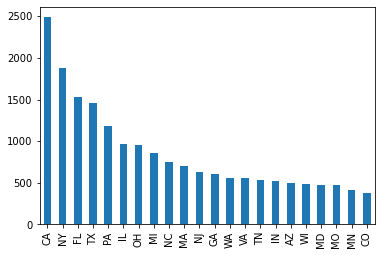

In [22]:
Prescriber["State"].value_counts().head(22).plot.bar()

#### We will look at Twelve Top States with Opioids

In [23]:
state = Prescriber["State"][Prescriber["Opioid.Prescriber"] == 1].value_counts(normalize=True)[:12]
state

CA    0.099923
TX    0.065262
FL    0.059940
NY    0.058819
PA    0.046425
OH    0.038303
MI    0.037953
IL    0.037322
NC    0.033681
GA    0.027449
MA    0.024648
WA    0.024578
Name: State, dtype: float64

<AxesSubplot:title={'center':'Number of US States where opiates are  prescribed the most'}>

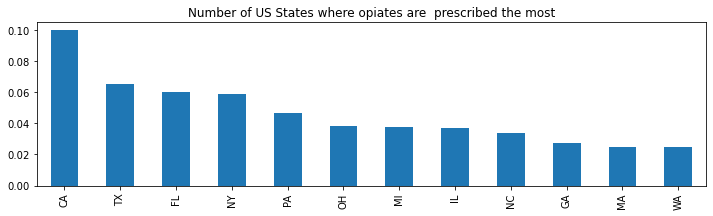

In [24]:
state = Prescriber["State"][Prescriber["Opioid.Prescriber"] == 1].value_counts(normalize=True)[:12]
state.sort_values(ascending=False).plot(
    kind="bar",
    figsize=(12,3),
    title="Number of US States where opiates are  prescribed the most")

In [25]:
count = Prescriber['Specialty'].value_counts()

<AxesSubplot:>

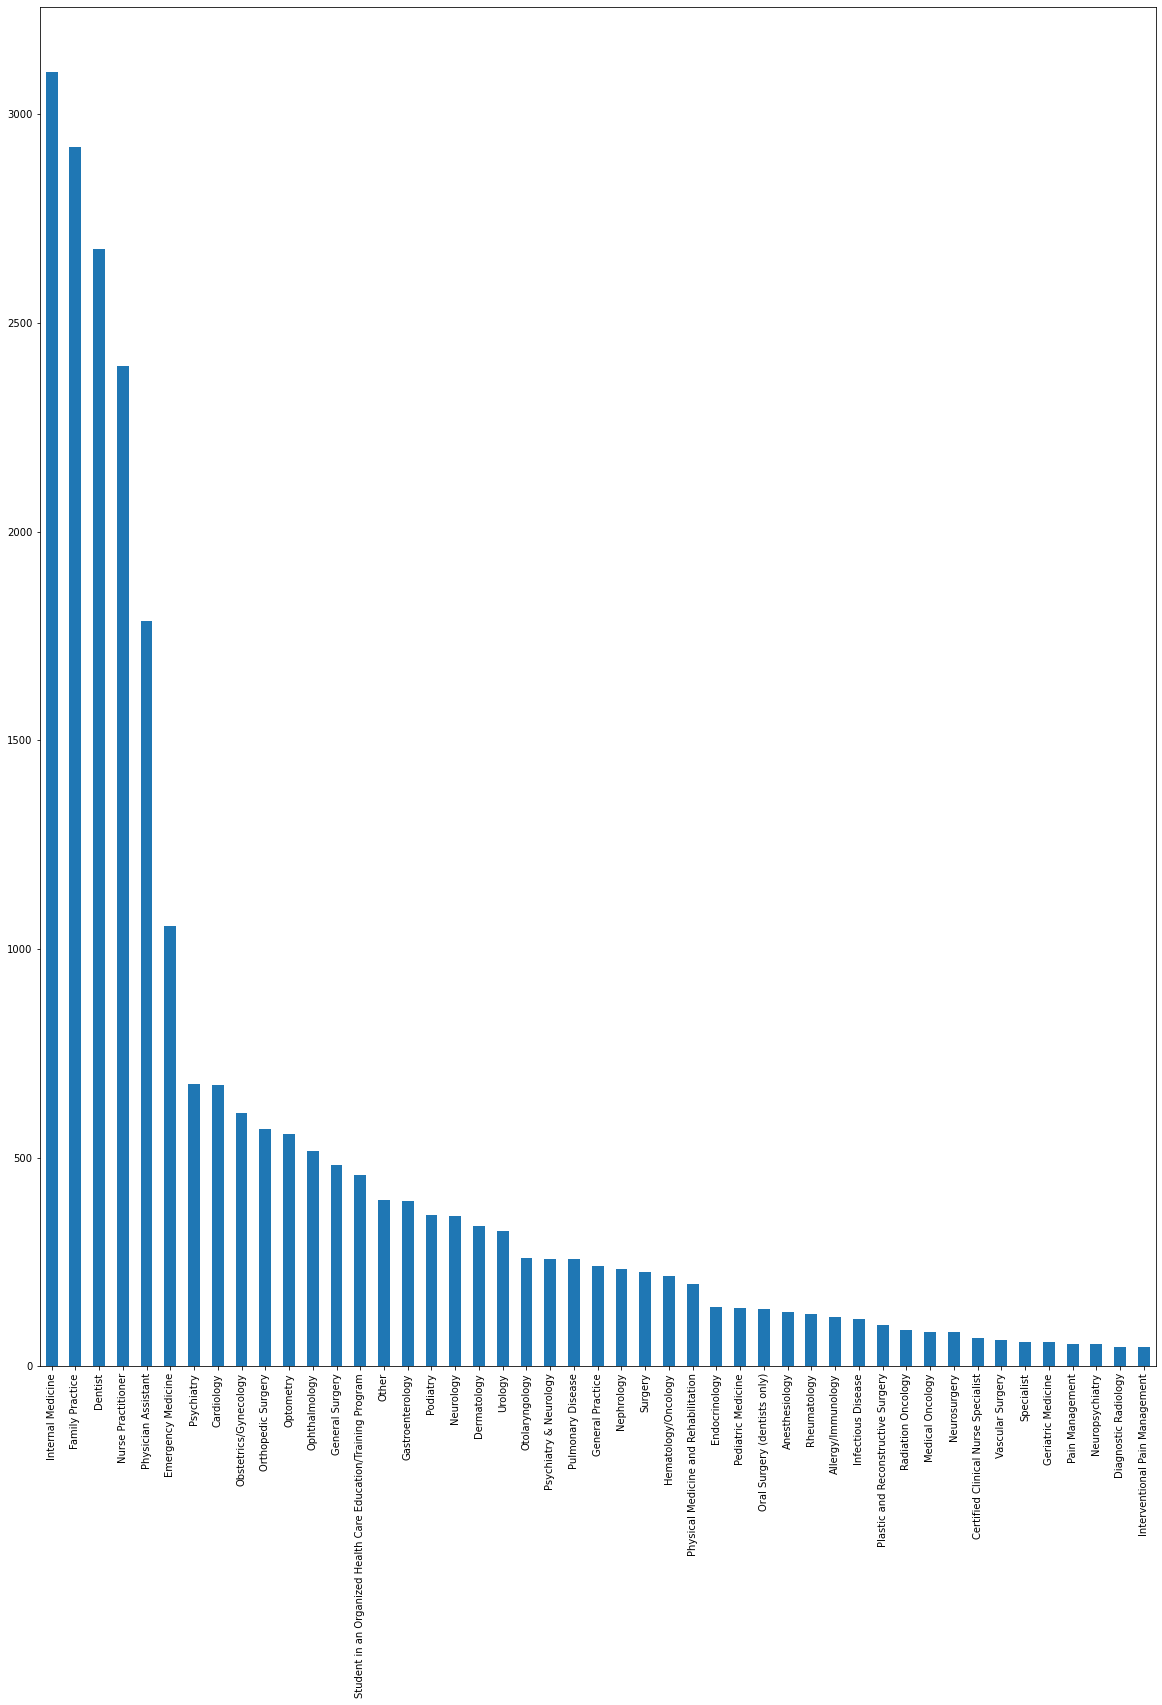

In [26]:
plt.figure(figsize=(20,25))
count.plot.bar()

In [27]:
pr = Prescriber[Prescriber['Opioid.Prescriber']==1].groupby('Specialty').count()['State'][:15]
pr.sort_values(ascending=False)

Specialty
Family Practice                        2586
Emergency Medicine                     1015
Dentist                                1009
General Surgery                         437
Hematology/Oncology                     199
General Practice                        181
Cardiology                              157
Gastroenterology                        114
Anesthesiology                           89
Dermatology                              60
Geriatric Medicine                       52
Endocrinology                            32
Certified Clinical Nurse Specialist      12
Diagnostic Radiology                     11
Allergy/Immunology                        7
Name: State, dtype: int64

<AxesSubplot:title={'center':'Kind of Medicine prescribing opiates'}, ylabel='Specialty'>

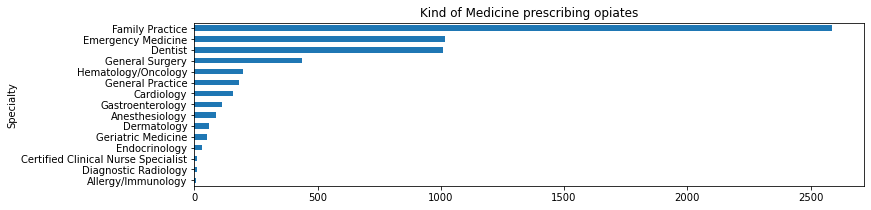

In [28]:
pr = Prescriber[Prescriber['Opioid.Prescriber']==1].groupby('Specialty').count()['State'][:15]

pr.sort_values(ascending=True).plot(
    kind="barh",
    figsize=(12,3),
    title="Kind of Medicine prescribing opiates")

#### Finally, create dummies from the categorical data.

In [29]:
Prescriber = pd.get_dummies(Prescriber, columns=['Specialty','State'], drop_first=True)

### Building the models: 

#### We are going to use 'Opioid.Prescriber' as a target variable to predict whether or not a prescriber will prescribe a drug. 

In [30]:
# load dataset
X = Prescriber.drop(['Opioid.Prescriber'],axis=1).values
y = Prescriber['Opioid.Prescriber'].values

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
X_train.shape, y_train.shape

((16965, 353), (16965,))

In [33]:
X_test.shape, y_test.shape

((7272, 353), (7272,))

In [34]:
# function that generates the model, predicts test data and prints confusion matrix. 
def fit_predict_score(name,clf):
    clf.fit(X_train, np.ravel(y_train))
    classes = ['No Opioid', 'Opioid']
    
    # training data:
    predicted = clf.predict(X_train)
    confusion_matrix =  pd.crosstab(index=np.ravel(y_train), columns=predicted.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(y_train , predicted),3)
    plt.title(name + " " + str(accuracy), fontsize = 15)
    plt.show()
    
    print("Training data:")
    print (metrics.classification_report(y_train,predicted, target_names=classes))
    
    # testing data
    predicted1 = clf.predict(X_test)
    confusion_matrix =  pd.crosstab(index=np.ravel(y_test), columns=predicted1.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(y_test , predicted1),3)
    plt.title(name + " " + str(accuracy), fontsize = 15)
    plt.show()
    print("Testing data:")
    print (metrics.classification_report(y_test,predicted1, target_names=classes))

/Users/yiannimercer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


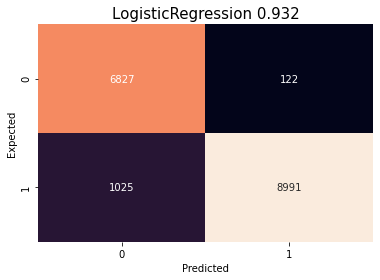

Training data:
              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.99      0.90      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965



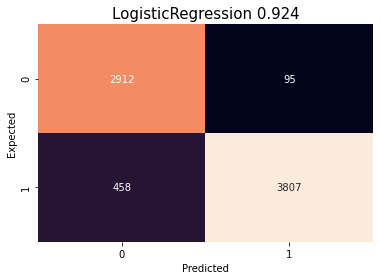

Testing data:
              precision    recall  f1-score   support

   No Opioid       0.86      0.97      0.91      3007
      Opioid       0.98      0.89      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.93      0.92      7272
weighted avg       0.93      0.92      0.92      7272



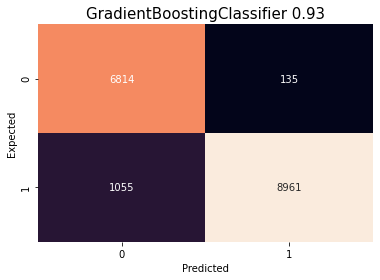

Training data:
              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.99      0.89      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965



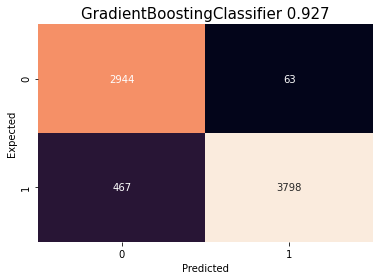

Testing data:
              precision    recall  f1-score   support

   No Opioid       0.86      0.98      0.92      3007
      Opioid       0.98      0.89      0.93      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.93      0.93      7272
weighted avg       0.93      0.93      0.93      7272



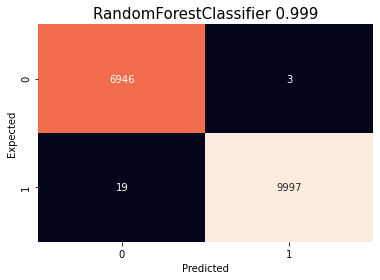

Training data:
              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965



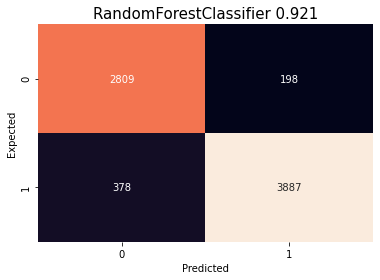

Testing data:
              precision    recall  f1-score   support

   No Opioid       0.88      0.93      0.91      3007
      Opioid       0.95      0.91      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.92      0.92      7272
weighted avg       0.92      0.92      0.92      7272



In [35]:
#initialize base classfiers
clf0 = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='auto', max_iter=1000)

#initialize challenger classfiers
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf2 = RandomForestClassifier(n_estimators=100)

#create an array of classifiers
names = ["LogisticRegression", "GradientBoostingClassifier", "RandomForestClassifier"]
classifiers= [clf0,clf1,clf2]

#loop through the classifiers
for name, clf in zip(names, classifiers):
    fit_predict_score(name,clf)

## Visualize Random Forest
##### Interesting tree. Very imbalanced!

In [ ]:
rf = clf2

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rf.estimators_[0],
               filled = True);

### Testing other models..

In [39]:
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train, y_train, cv=5)
scores.mean()

0.9088122605363985

In [40]:
dtree = DecisionTreeClassifier(random_state=0)
scores = cross_val_score(dtree, X_train, y_train, cv=5)
scores.mean()

0.8979664014146772

In [42]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=0)
scores = cross_val_score(adaboost, X_train, y_train, cv=5)
scores.mean()

0.9260241674034777

# Voting Classifier 
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels.   
Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

Let's create 6 models, make predictions, and take the average of these predictions to come with a hard voting classifier solution

### Soft Voting:

In [46]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(random_state=1)
clf5 = DecisionTreeClassifier(random_state=1)
clf6 = GradientBoostingClassifier(random_state=1)

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('ada', clf4), ('dtree',clf5), ('gboost',clf6)],
    voting='soft')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.918 (+/- 0.002) [Logistic Regression]
Accuracy: 0.922 (+/- 0.002) [Random Forest]
Accuracy: 0.909 (+/- 0.005) [Naive Bayes]
Accuracy: 0.926 (+/- 0.004) [AdaBoost]
Accuracy: 0.900 (+/- 0.004) [Decision Tree]
Accuracy: 0.924 (+/- 0.005) [Gradient Boosting]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.925 (+/- 0.004) [Ensemble]


### Hard Voting:

In [47]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(random_state=1)
clf5 = DecisionTreeClassifier(random_state=1)
clf6 = GradientBoostingClassifier(random_state=1)

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('ada', clf4), ('dtree',clf5), ('gboost',clf6)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.918 (+/- 0.002) [Logistic Regression]
Accuracy: 0.922 (+/- 0.002) [Random Forest]
Accuracy: 0.909 (+/- 0.005) [Naive Bayes]
Accuracy: 0.926 (+/- 0.004) [AdaBoost]
Accuracy: 0.900 (+/- 0.004) [Decision Tree]
Accuracy: 0.924 (+/- 0.005) [Gradient Boosting]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.926 (+/- 0.004) [Ensemble]


#### We can see that the ensembled model with all the 6 models performed the same with soft and hard voting. All the models have high accuracy scores. I will further use the test set to compare the performances between the models.

## Evaluating with the test set with the Hard Voting..

In [55]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    fit = clf.fit(X_train,y_train)
    pred = fit.predict(X_test)
    accuracy=accuracy_score(y_test,pred)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (accuracy.mean(), accuracy.std(), label))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.920 (+/- 0.000) [Logistic Regression]
Accuracy: 0.923 (+/- 0.000) [Random Forest]
Accuracy: 0.914 (+/- 0.000) [Naive Bayes]
Accuracy: 0.929 (+/- 0.000) [AdaBoost]
Accuracy: 0.902 (+/- 0.000) [Decision Tree]
Accuracy: 0.927 (+/- 0.000) [Gradient Boosting]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.928 (+/- 0.000) [Ensemble]
